<a href="https://colab.research.google.com/github/PrithaSarkar/Dissertation/blob/main/Pull_request_Analysis_%26_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Availability**

In [35]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


Installing/upgrading and importing the necessary packages for experiment.


In [36]:
!pip install --upgrade missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip install --upgrade hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!pip install --upgrade shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip install --upgrade mxnet gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sklearn

Mounting drive and loading the datafile. Change the location as applicable.

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation UofG 2022/new_pullreq.csv")
df

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,258,25263316,Kronos-Integration,kronos-service-consul,1,9,9.0,1,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,27876,9812944,saltstack,salt,0,1165,NaN,1,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,444,19063491,mjmlio,mjml,1,8834,8834.0,2,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,651,2087506,zotonic,zotonic,0,703,NaN,7,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [3]:
columns = df.columns.to_list()
print(len(columns))
print(columns)

120
['id', 'project_id', 'github_id', 'pull_request_id', 'ownername', 'reponame', 'merged_or_not', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'src_churn', 'test_churn', 'files_added', 'files_deleted', 'files_modified', 'files_changed', 'src_files', 'doc_files', 'other_files', 'num_commit_comments', 'num_issue_comments', 'num_comments', 'num_participants', 'sloc', 'team_size', 'perc_external_contribs', 'commits_on_files_touched', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'prev_pullreqs', 'requester_succ_rate', 'followers', 'churn_addition', 'churn_deletion', 'pr_comment_num', 'comment_num', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'part_num_code', 'comment_conflict', 'hash_tag', 'at_tag', 'test_inclusion', 'description_length', 'bug_fix', 'ci_exists', 'ci_latency', 'ci_build_num', 'ci_test_passed', 'ci_failed_perc', 'ci_first_build_status', 'ci_last_build_status', 'lan

The "merged_or_not" metric states whether a pull-request was accepted or not. Let us check, how many of the 3 million pull-request was accepted and how many were rejected.

In [4]:
def class_balance(dataframe):
  accepted = 0
  rejected = 0
  for ind in dataframe.index:
    if dataframe["merged_or_not"][ind]==1:
      accepted = accepted+1
    else:
      rejected = rejected+1
  print("Accepted:", accepted)
  print("Percentage:", (accepted/len(dataframe))*100)
  print("Rejected:", rejected)
  print("Percentage:", (rejected/len(dataframe))*100)

In [5]:
class_balance(df)

Accepted: 2710096
Percentage: 80.94823767591804
Rejected: 637841
Percentage: 19.051762324081963


There is a huge imbalance in the two classes. This needs to be kept in mind from this point onwards.

The original dataset has 120 columns/metrics related to each pull-request. However, we will only focus on the metrics present in Table 1 of [this paper](https://dl.acm.org/doi/10.1145/3379597.3387489).

Code in the next 2 cells were taken from [this](https://stackoverflow.com/a/57198258) blog.

In [6]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [7]:
chunk_size = len(df)/2
get_chunk = flow_from_df(df, int(chunk_size))
train_test = next(get_chunk)
train_test

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,8504763,1205,20816393,os-autoinst,openQA,1,77,77.0,1,...,1,2,0,0,6.0,1,0.119597,0,77,0
1673964,1673965,10789805,141,4184228,geopandas,geopandas,1,418,418.0,4,...,1,2,0,0,48.0,0,0.037736,0,418,0
1673965,1673966,26051663,5794,45711167,JMRI,JMRI,1,151,151.0,1,...,0,0,0,0,51.0,0,0.094772,0,151,0
1673966,1673967,4952323,91,2361445,spring-projects,spring-data-mongodb,0,122689,NaN,3,...,0,0,0,0,149.0,0,0.478788,0,122689,0


In [8]:
list_of_metrics = ['id','acc_commit_num', 'first_pr', 'core_member',
                  'contrib_gender', 'same_country', 'same_affiliation',
                  'social_strength', 'account_creation_days',
                  'first_response_time', 'contrib_country',
                  'prior_interaction', 'contrib_affiliation', 'perc_external_contribs',
                  'contrib_first_emo', 'contrib_follow_integrator',
                  'language', 'project_age', 'pushed_delta',
                  'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num',
                  'churn_addition', 'bug_fix', 'test_inclusion',
                  'hash_tag', 'at_tag', 'part_num_issue', 'part_num_commit',
                  'part_num_pr', 'part_num_code','ci_exists', 'ci_latency',
                  'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                  'description_length', 'comment_conflict', 'pr_comment_num',
                  'part_num_code', 'ci_build_num', 'perc_inte_neg_emo', 'perc_inte_pos_emo',
                  'perc_inte_neu_emo','ci_first_build_status', 'ci_last_build_status',
                   'merged_or_not']

In [9]:
for metric in columns:
  if metric not in list_of_metrics:
    train_test.drop(metric, axis=1, inplace=True)

train_test

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,1.000000,0,28,0.000000,NaN,NaN
1,2,0,0.014019,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,300,0.250000,NaN,NaN
2,3,1,0.256849,0,0,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,505,0.428571,1.0,NaN
3,4,1,0.014706,110,3,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,460,0.138889,NaN,NaN
4,5,1,0.173077,60,0,0,1,0,0,0,...,NaN,NaN,0.000000,1.0,0.000000,1,6,0.125000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,1,0.011392,4,0,0,3,0,0,0,...,suse,neutral,0.000000,1.0,0.000000,0,132,0.384615,NaN,1.0
1673964,1673965,1,0.018182,173,2,0,4,0,0,0,...,mapbox,neutral,0.333333,0.0,0.666667,0,36,0.400000,1.0,0.0
1673965,1673966,1,0.254067,1,0,0,0,0,0,0,...,acm,NaN,0.000000,0.0,0.000000,0,204,0.215686,1.0,1.0
1673966,1673967,0,0.150327,15,14,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,88,0.285714,NaN,NaN


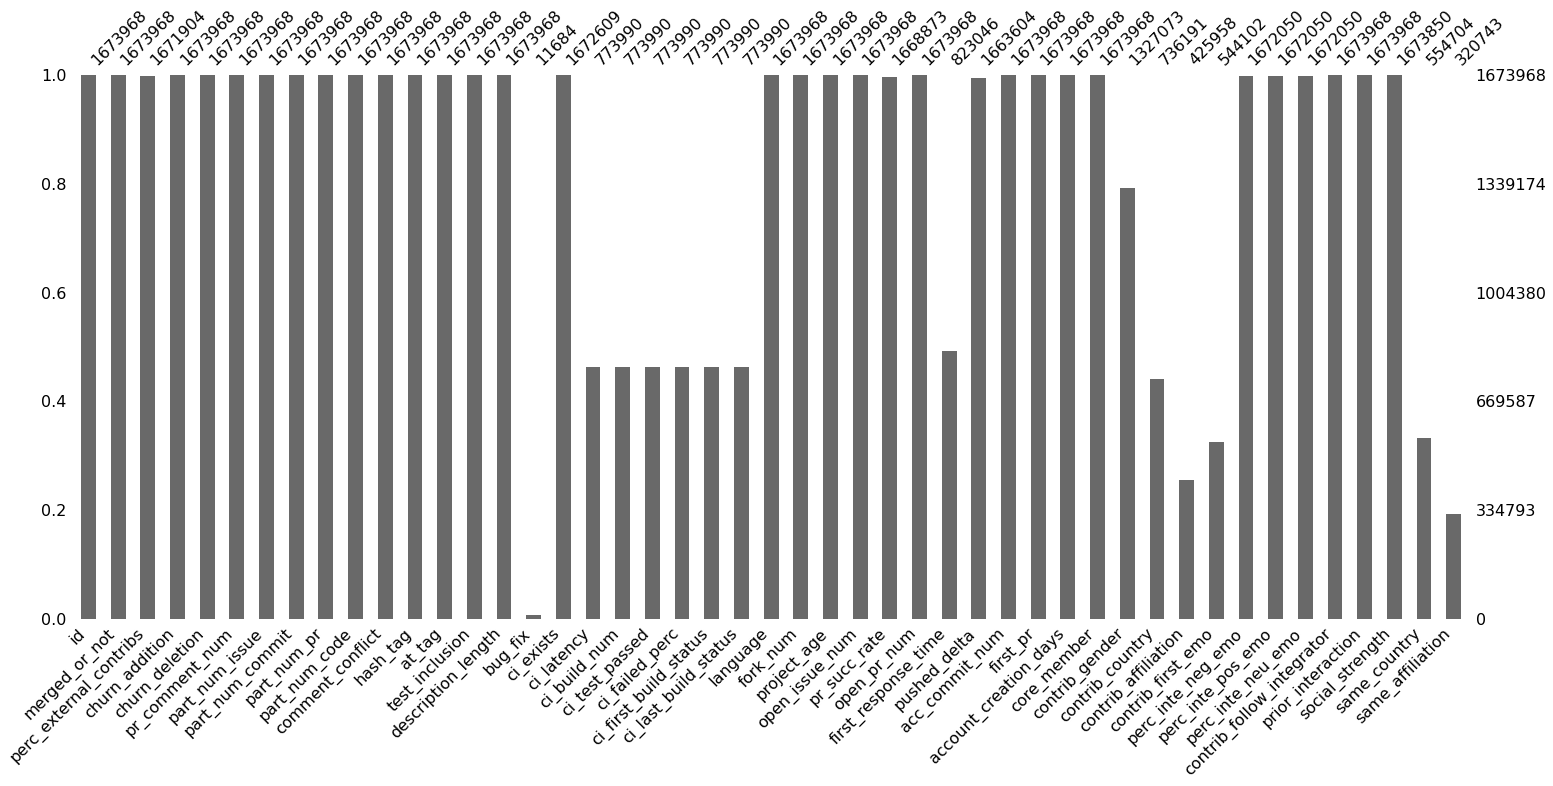

In [10]:
msno.bar(train_test)

A huge amount of data is missing. Preprocessing is a must at this stage. Although a couple of way of preprocessing data exists, the decision to exchange the NaN values with a the most commonly occuring one for individual column has been adapted.

In [11]:
train_test = train_test.fillna(train_test.mode().iloc[0])

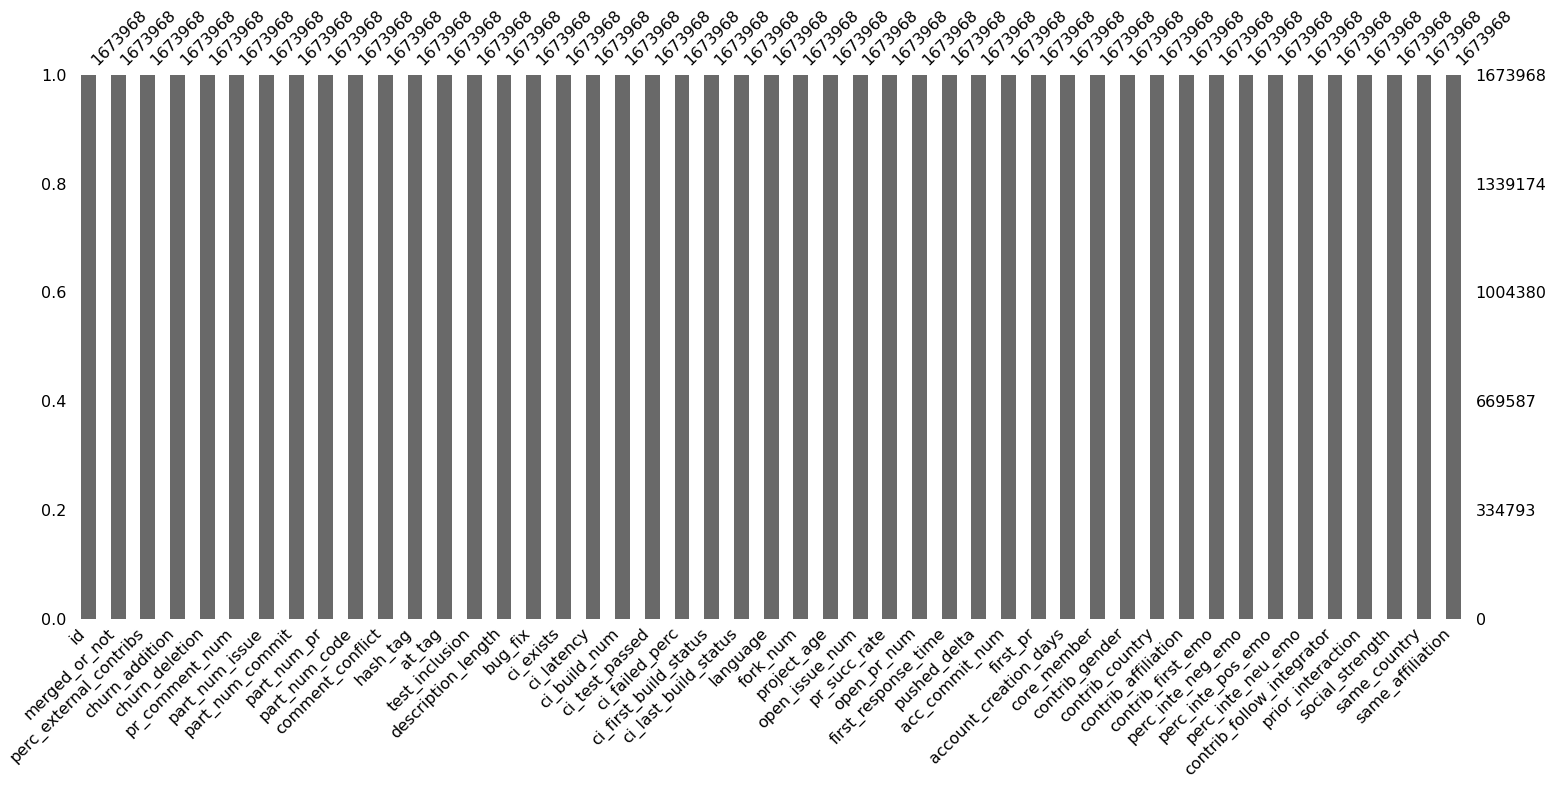

In [12]:
msno.bar(train_test)

Let us now see the percentage of accepted and rejected pull-request in this data chunk and see if the class imbalance remains the same or has worsened.

In [13]:
class_balance(train_test)

Accepted: 1355422
Percentage: 80.97060397809277
Rejected: 318546
Percentage: 19.029396021907232


An important step before that would be to check the data types of every column since classification models would expect int, bool or float daat types. However, the dataset is diverse and annotation is required.

In [14]:
print(train_test.dtypes)

id                             int64
merged_or_not                  int64
perc_external_contribs       float64
churn_addition                 int64
churn_deletion                 int64
pr_comment_num                 int64
part_num_issue                 int64
part_num_commit                int64
part_num_pr                    int64
part_num_code                  int64
comment_conflict               int64
hash_tag                       int64
at_tag                         int64
test_inclusion                 int64
description_length             int64
bug_fix                      float64
ci_exists                    float64
ci_latency                   float64
ci_build_num                 float64
ci_test_passed               float64
ci_failed_perc               float64
ci_first_build_status         object
ci_last_build_status          object
language                      object
fork_num                       int64
project_age                    int64
open_issue_num                 int64
p

Metrics "ci_first_build_status", "ci_last_build_status", "language", "contrib_gender", contrib_country", "contrib_affiliation", "contrib_first_emo" have data type of object. This would cause trouble when deploying XGBoost. Annotation is needed in this case; manual or otherwise. Let's check the unique values present in each of these metrics.

In [15]:
object_metrics = ['ci_first_build_status', 'ci_last_build_status', 'language', 
                  'contrib_gender', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo']

for metric in object_metrics:
    globals()['unique_%s' % metric] = train_test[metric].unique()
    print(metric,':', len(train_test[metric].unique()))

ci_first_build_status : 2
ci_last_build_status : 2
language : 6
contrib_gender : 2
contrib_country : 175
contrib_affiliation : 1202
contrib_first_emo : 3


Annotation has been done manually after creation of dictionaries. This was done to harvest the values and their corresponding labels for future purposes. Another thing to note is that the labels start from '1' as opposed to '0' like in LabelEncoder. This decision was taken due to problem encountered in the later half of the experiment. More explanation regarding this will be available later on during the recommendation process.

In [16]:
for metric in object_metrics:
    if metric == 'ci_first_build_status':
        dict_ci_first_build_status = {}
        value = 1
        for key in unique_ci_first_build_status:
            dict_ci_first_build_status[key] = value
            value += 1 
    if metric == 'ci_last_build_status':
        dict_ci_last_build_status = {}
        value = 1
        for key in unique_ci_last_build_status:
            dict_ci_last_build_status[key] = value
            value += 1 
    if metric == 'language':
        dict_language = {}
        value = 1
        for key in unique_language:
            dict_language[key] = value
            value += 1
    if metric == 'contrib_gender':
        dict_contrib_gender = {}
        value = 1
        for key in unique_contrib_gender:
            dict_contrib_gender[key] = value
            value += 1 
    if metric == 'contrib_country':
        dict_contrib_country = {}
        value = 1
        for key in unique_contrib_country:
            dict_contrib_country[key] = value
            value += 1 
    if metric == 'contrib_affiliation':
        dict_contrib_affiliation = {}
        value = 1
        for key in unique_contrib_affiliation:
            dict_contrib_affiliation[key] = value
            value += 1 
    if metric == 'contrib_first_emo':
        dict_contrib_first_emo = {}
        value = 1
        for key in unique_contrib_first_emo:
            dict_contrib_first_emo[key] = value
            value += 1

In [17]:
for metric in object_metrics:
    if metric == 'ci_first_build_status':
        for key in dict_ci_first_build_status:
            train_test[metric].replace(key, dict_ci_first_build_status[key], inplace = True)
    if metric == 'ci_last_build_status':
        for key in dict_ci_last_build_status:
            train_test[metric].replace(key, dict_ci_last_build_status[key], inplace = True)
    if metric == 'language':
        for key in dict_language:
            train_test[metric].replace(key, dict_language[key], inplace = True)
    if metric == 'contrib_gender':
        for key in dict_contrib_gender:
            train_test[metric].replace(key, dict_contrib_gender[key], inplace = True)
    if metric == 'contrib_country':
        for key in dict_contrib_country:
            train_test[metric].replace(key, dict_contrib_country[key], inplace = True)
    if metric == 'contrib_affiliation':
        for key in dict_contrib_affiliation:
            train_test[metric].replace(key, dict_contrib_affiliation[key], inplace = True)
    if metric == 'contrib_first_emo':
        for key in dict_contrib_first_emo:
            train_test[metric].replace(key, dict_contrib_first_emo[key], inplace = True)

In [18]:
train_test.language

0          1
1          2
2          1
3          3
4          2
          ..
1673963    1
1673964    2
1673965    5
1673966    5
1673967    1
Name: language, Length: 1673968, dtype: int64

The train_test dataframe is divided into two. One will be used to train the model while the other will be used for testing. The training sample will contain 60% of the rows present in the original train_test dataframe while the testing sample will contain the remaining 40%.

In [19]:
chunk_size = int(len(train_test)*0.6)
get_chunk = flow_from_df(train_test, chunk_size)
train = next(get_chunk)

In [20]:
test = train_test.iloc[(train.index[-1]+1):train_test.index[-1], :]

In [21]:
len(train), len(test)

(1004380, 669587)

In [22]:
train.head(1)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,1,1,0.0,0.0,1.0,0,28,0.0,1.0,1.0


In [23]:
test.head(1)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
1004380,1004381,1,0.0,0,0,0,4,0,0,0,...,94,1,0.0,0.0,0.0,0,523,0.714286,1.0,1.0


# ***XGBoost***

In [24]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

Hyperparameter Tuning of XGBoost.

The next 3 cells contain code from the Kaggle notebook "[A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)"



In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}

def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(train.iloc[:, 2:], train["merged_or_not"]), (test.iloc[:, 2:], test["merged_or_not"])]
    
    clf.fit(train.iloc[:, 2:], train["merged_or_not"],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test.iloc[:, 2:])
    accuracy = accuracy_score(test["merged_or_not"], pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [25]:
best_hyperparams = {'colsample_bytree': 0.506045605054534, 'gamma': 1.9731213715698703, 
                    'max_depth': 13.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.564408815848497}

In [26]:
X = train.iloc[:, 2:]
y = train["merged_or_not"]

In [27]:
model = xgb.XGBClassifier(max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']), min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']))

First trail with fit and predict.

In [28]:
#Fitting the model
start=datetime.now()

model.fit(X,y)

print("Computation Time")
print(datetime.now()-start)

#Prediction
y_pred = model.predict(test.iloc[:, 2:])
print("Prediction")
print(y_pred)

Computation Time
0:00:21.193379
Prediction
[1 1 1 ... 1 1 1]


In [29]:
results = (test['merged_or_not'] == y_pred)
accuracy = results.sum() / results.size
print(accuracy)

0.8277311238121409


The "evaluation_summary" function is copied from [this](https://colab.research.google.com/drive/1W3WdSNqdnuuu8GLGr28TSEbpC46LW7f2) notebook.

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, true_labels, predictions, target_classes):
  print("Evaluation for: " + description)
  target_names = target_classes
  report = classification_report(true_labels, predictions,  digits=3, zero_division=0, target_names=target_names)
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(5,5))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title("Confusion Matrix")
  ax.xaxis.set_ticklabels(target_names) 
  ax.yaxis.set_ticklabels(target_names)
  return report

Evaluation for: Baseline Model
              precision    recall  f1-score   support

    Rejected      0.695     0.163     0.264    126934
    Accepted      0.834     0.983     0.902    542653

    accuracy                          0.828    669587
   macro avg      0.764     0.573     0.583    669587
weighted avg      0.808     0.828     0.781    669587



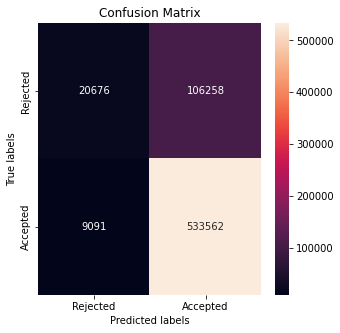

In [31]:
target_classes = ['Rejected', 'Accepted']
print(evaluation_summary("Baseline Model", test["merged_or_not"], y_pred , target_classes))

ROC-AUC curve code taken from [here](https://www.kaggle.com/code/beletecheneke/xgboost-with-roc-curve-notebook-auprc-93) 

In [32]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
def roc_auc_curve(test_results, y_pred):
  fpr, tpr, _ = roc_curve(test_results.values, y_pred)
  roc_auc = auc(fpr, tpr)
  #xgb.plot_importance(gbm)
  #plt.show()
  plt.figure(figsize=(5,5))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

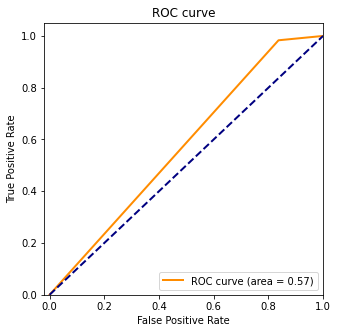

In [33]:
roc_auc_curve(test["merged_or_not"], y_pred)

### **Feature Selection with XGBoost**

Study [this](https://notebook.community/minesh1291/MachineLearning/xgboost/feature_importance_v1) to understand how feature importance is decided in the following graph.

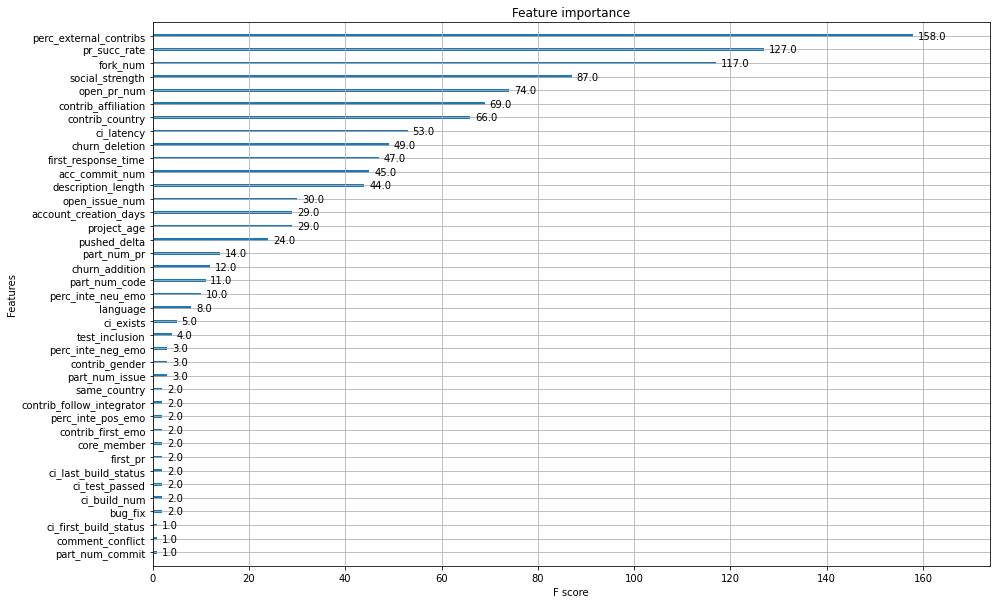

In [34]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(model)
plt.show()

We can see that some features work very poorly and contribute very little to the model. Attempt now should be made to identify the most important features without damaging the model score.

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [36]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]

for index in sorted_idx:
  print([X.columns[index], model.feature_importances_[index]])

['ci_last_build_status', 0.23996039]
['core_member', 0.23593336]
['part_num_issue', 0.16061245]
['ci_build_num', 0.054171726]
['ci_first_build_status', 0.041376572]
['first_pr', 0.04090331]
['ci_exists', 0.02614957]
['part_num_commit', 0.025500331]
['acc_commit_num', 0.022627039]
['perc_inte_pos_emo', 0.021209408]
['contrib_follow_integrator', 0.021032399]
['contrib_first_emo', 0.014595332]
['same_country', 0.012426201]
['language', 0.010328107]
['ci_test_passed', 0.009435813]
['open_pr_num', 0.0075981733]
['description_length', 0.00701664]
['open_issue_num', 0.006905698]
['account_creation_days', 0.0054122065]
['pr_succ_rate', 0.004028126]
['first_response_time', 0.0037981686]
['fork_num', 0.0033574612]
['ci_latency', 0.0029261701]
['contrib_gender', 0.0025455211]
['project_age', 0.0021149688]
['comment_conflict', 0.002082463]
['churn_deletion', 0.0020254715]
['contrib_affiliation', 0.00202366]
['pushed_delta', 0.0018857354]
['perc_inte_neu_emo', 0.0018369576]
['part_num_pr', 0.001761

**Strategy 1:** Using the mean of the feature importance scores to determine the best performing features.

In [37]:
sum = 0.0
for value in model.feature_importances_:
  sum = sum+value

threshold_1 = sum/len(model.feature_importances_)
print(threshold_1)

0.022222223046184


In [38]:
imp_features_1 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_1:
    imp_features_1.append(X.columns[index])

print(imp_features_1)
print(len(imp_features_1))

['ci_last_build_status', 'core_member', 'part_num_issue', 'ci_build_num', 'ci_first_build_status', 'first_pr', 'ci_exists', 'part_num_commit', 'acc_commit_num']
9


In [39]:
model_new = xgb.XGBClassifier(max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']), min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']))

In [40]:
X_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  X_new_1[feature] = train[feature]

start=datetime.now()

model_new.fit(X_new_1, y)

print("Computation Time")
print(datetime.now()-start)

test_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  test_new_1[feature] = test[feature]

y_pred_new_1 = model_new.predict(test_new_1)

Computation Time
0:00:10.441092


In [41]:
results_new_1 = (test["merged_or_not"] == y_pred_new_1)
accuracy_new_1 = results_new_1.sum() / results_new_1.size
print(accuracy_new_1)

0.8205401239868755


Evaluation for: Performance of new model with fewer features
              precision    recall  f1-score   support

    Rejected      0.595     0.168     0.262    126934
    Accepted      0.833     0.973     0.898    542653

    accuracy                          0.821    669587
   macro avg      0.714     0.570     0.580    669587
weighted avg      0.788     0.821     0.777    669587



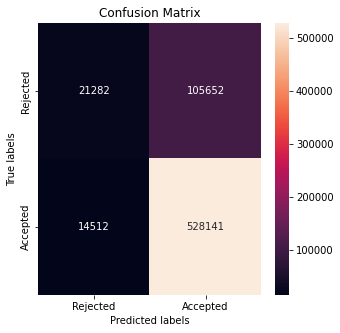

In [42]:
print(evaluation_summary("Performance of new model with fewer features", test["merged_or_not"], y_pred_new_1 , target_classes))

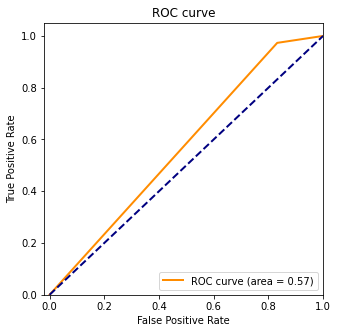

In [43]:
roc_auc_curve(test["merged_or_not"], y_pred_new_1)

Read [this](https://ai.stanford.edu/blog/removing-spuriousfeature/).
[Deciding the threshold for feature importance.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00472-4)

**Strategy 2:** Standard Deviation for determining threshold.

In [44]:
threshold_2 = np.std(model.feature_importances_)
print(threshold_2)

0.05306489


In [45]:
imp_features_2 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_2:
    feature_to_consider_1 = X.columns[index]
    imp_features_2.append(feature_to_consider_1)

print(imp_features_2)
print(len(imp_features_2))

['ci_last_build_status', 'core_member', 'part_num_issue', 'ci_build_num']
4


In [46]:
X_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  X_new_2[feature] = train[feature]

start=datetime.now()

model_new.fit(X_new_2, y)

print("Computation Time")
print(datetime.now()-start)

test_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  test_new_2[feature] = test[feature]

y_pred_new_2 = model_new.predict(test_new_2)

Computation Time
0:00:06.044129


In [47]:
results_new_2 = (test["merged_or_not"] == y_pred_new_2)
accuracy_new_2 = results_new_2.sum() / results_new_2.size
print(accuracy_new_2)

0.8131624419231556


Evaluation for: Performance of new model with fewer features
              precision    recall  f1-score   support

    Rejected      0.576     0.055     0.100    126934
    Accepted      0.818     0.991     0.896    542653

    accuracy                          0.813    669587
   macro avg      0.697     0.523     0.498    669587
weighted avg      0.772     0.813     0.745    669587



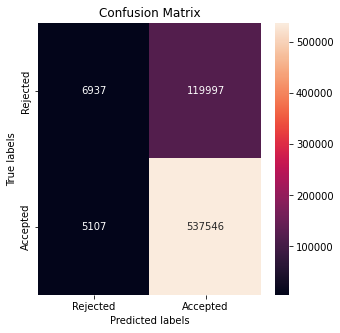

In [48]:
print(evaluation_summary("Performance of new model with fewer features", test["merged_or_not"], y_pred_new_2 , target_classes))

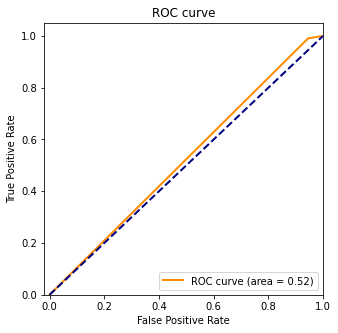

In [49]:
roc_auc_curve(test["merged_or_not"], y_pred_new_2)

**Strategy 3:** Derivatives of feature importance values where dy = the feature importance value itself and dx = the mean of all the feature importance values. Determining the average of the dydx values for threshold.

In [50]:
from numpy import diff

dx = threshold_1
features_dydx = diff(model.feature_importances_)/dx

In [51]:
sum = 0.0
for value in features_dydx:
  sum = sum+value
threshold_3 = sum/len(features_dydx)
print(threshold_3)

-0.001467584463005716


In [52]:
imp_features_3 = []
for index in sorted_idx-1:
  for val in features_dydx:
    if val >= threshold_3:
      feature_to_consider_2 = X.columns[index]
  imp_features_3.append(feature_to_consider_2)

print(imp_features_3)
print(len(imp_features_3))

['ci_first_build_status', 'account_creation_days', 'pr_comment_num', 'ci_latency', 'ci_failed_perc', 'acc_commit_num', 'bug_fix', 'part_num_issue', 'pushed_delta', 'perc_inte_neg_emo', 'perc_inte_neu_emo', 'contrib_affiliation', 'social_strength', 'ci_last_build_status', 'ci_build_num', 'pr_succ_rate', 'test_inclusion', 'project_age', 'first_pr', 'open_issue_num', 'open_pr_num', 'language', 'ci_exists', 'core_member', 'fork_num', 'part_num_code', 'churn_addition', 'contrib_country', 'first_response_time', 'perc_inte_pos_emo', 'part_num_commit', 'same_affiliation', 'part_num_pr', 'contrib_first_emo', 'perc_external_contribs', 'prior_interaction', 'at_tag', 'contrib_gender', 'description_length', 'hash_tag', 'comment_conflict', 'ci_test_passed', 'contrib_follow_integrator', 'churn_deletion', 'same_country']
45


In [53]:
X_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  X_new_3[feature] = train[feature]

start=datetime.now()

model_new.fit(X_new_3, y)

print("Computation Time")
print(datetime.now()-start)

test_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  test_new_3[feature] = test[feature]

y_pred_new_3 = model_new.predict(test_new_3)

Computation Time
0:00:19.459880


In [54]:
results_new_3 = (test["merged_or_not"] == y_pred_new_3)
accuracy_new_3 = results_new_3.sum() / results_new_3.size
print(accuracy_new_3)

0.8280641649255437


Evaluation for: Performance of new model with fewer features
              precision    recall  f1-score   support

    Rejected      0.706     0.159     0.260    126934
    Accepted      0.833     0.985     0.903    542653

    accuracy                          0.828    669587
   macro avg      0.770     0.572     0.581    669587
weighted avg      0.809     0.828     0.781    669587



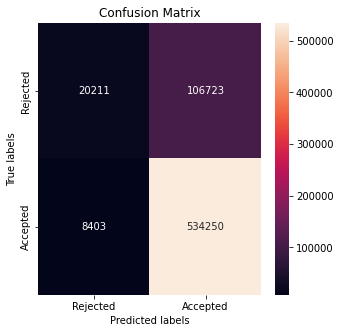

In [55]:
print(evaluation_summary("Performance of new model with fewer features", test["merged_or_not"], y_pred_new_3 , target_classes))

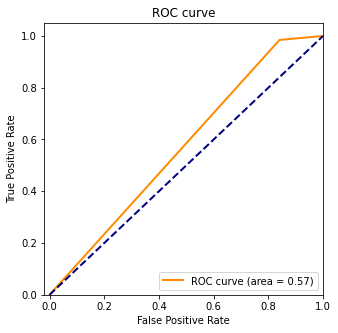

In [56]:
roc_auc_curve(test["merged_or_not"], y_pred_new_3)

Feature Selection with information gain and entropy.
[Here](https://www.kaggle.com/code/ma7555/decision-trees-information-gain-from-scratch), [here](https://https://www.sciencedirect.com/science/article/pii/S0957417420302001).

**Strategy 4:** Information Gain and Entropy for feature selection.

*Important note::* The following cell is not working with a high amount of data present in the "train" dataframe, i.e., half of the original dataset, due to resource restriction. Hence, half of the "train" dataset, i.e., one-fourth of the original dataset, has been used in this strategy.

In [57]:
chunk_size = len(train)/2
get_chunk = flow_from_df(train, int(chunk_size))
ige = next(get_chunk)

In [58]:
import math
from collections import Counter

feature_gain = pd.DataFrame(columns = ["feature", "gain"])

def entropy(labels):
    entropy=0
    label_counts = Counter(labels)
    for label in label_counts:
        prob_of_label = label_counts[label] / len(labels)
        entropy -= prob_of_label * math.log2(prob_of_label)
    return entropy

def information_gain(starting_labels, split_labels):
    info_gain = entropy(starting_labels)
    for branched_subset in split_labels:
        info_gain -= len(branched_subset) * entropy(branched_subset) / len(starting_labels)
    return info_gain

def split(dataset, column):
    split_data = []
    col_vals = dataset[column].unique()
    for col_val in col_vals:
        split_data.append(dataset[dataset[column] == col_val])
    return(split_data)

def find_best_split(dataset):
  global feature_gain 
  feature_gain = pd.DataFrame(columns=['feature', 'gain'])
  best_gain = 0
  best_feature = 0
  features = list(dataset.columns)
  features.remove('merged_or_not')
  for feature in features:
    split_data = split(dataset, feature)
    split_labels = [dataframe['merged_or_not'] for dataframe in split_data]
    gain = information_gain(dataset['merged_or_not'], split_labels)
    new_row = {'feature': feature, 'gain': gain}
    feature_gain = feature_gain.append(new_row, ignore_index = True)
    if gain>best_gain:
      best_gain = gain
      best_feature = feature
  return best_feature, best_gain

new_data = split(ige, find_best_split(ige)[0])

In [59]:
feature_gain = feature_gain.sort_values(by=['gain'])

feature_gain

,feature,gain
44,same_country,0.000016
45,same_affiliation,0.000026
14,bug_fix,0.000065
12,test_inclusion,0.000069
10,hash_tag,0.000151
34,contrib_gender,0.000196
9,comment_conflict,0.000211
39,perc_inte_pos_emo,0.000506
4,pr_comment_num,0.000519
38,perc_inte_neg_emo,0.000571


'id' metric is irrelevant in this context and hence will be droped in the next cell.

In [60]:
feature_gain.drop(feature_gain.index[-1], axis=0, inplace = True)

**Strategy 4.1:** Using the mean value of the gains of the features.

In [61]:
sum = 0.0
for rows in feature_gain.itertuples():
  sum = sum+rows.gain

threshold_4 = sum/len(feature_gain)
print(threshold_4)

0.02706200695034934


In [62]:
imp_features_4 = []
for rows in feature_gain.itertuples():
  if rows.gain>=threshold_4:
    imp_features_4.append(rows.feature)

print(imp_features_4)
print(len(imp_features_4))

['part_num_issue', 'prior_interaction', 'ci_latency', 'fork_num', 'acc_commit_num', 'first_response_time', 'social_strength', 'pr_succ_rate', 'perc_external_contribs', 'pushed_delta']
10


In [63]:
X_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  X_new_4[feature] = train[feature]

start=datetime.now()

model_new.fit(X_new_4, y)

print("Computation Time")
print(datetime.now()-start)

test_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  test_new_4[feature] = test[feature]

y_pred_new_4 = model_new.predict(test_new_4)

Computation Time
0:00:29.945734


In [64]:
results_new_4 = (test["merged_or_not"] == y_pred_new_4)
accuracy_new_4 = results_new_4.sum() / results_new_4.size
print(accuracy_new_4)

0.8224442828191109


Evaluation for: Performance of new Model with less features
              precision    recall  f1-score   support

    Rejected      0.620     0.163     0.258    126934
    Accepted      0.833     0.977     0.899    542653

    accuracy                          0.822    669587
   macro avg      0.727     0.570     0.579    669587
weighted avg      0.793     0.822     0.778    669587



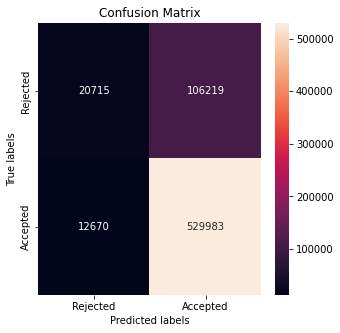

In [65]:
print(evaluation_summary("Performance of new Model with less features", test["merged_or_not"], y_pred_new_4, target_classes))

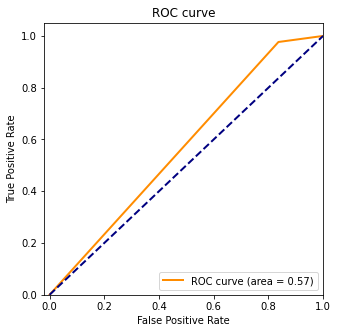

In [66]:
roc_auc_curve(test["merged_or_not"], y_pred_new_4)

### **Evaluation and Recommendation**

In [67]:
def recommendation_metrics(imp_features, pull_request_chars):
  reco = []
  for feature in imp_features:
    if feature in pull_request_chars:
      reco.append(feature)
  return reco

In [68]:
pull_request_characteristics = ['churn_addition', 'bug_fix', 'test_inclusion',
                                'at_tag', 'part_num_X', 'ci_exists', 'ci_latency',
                                'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                                'description_length', 'comment_conflict', 'pr_comment_num',
                                'part_num_code', 'ci_build_num', 'perc_neg_emotion',
                                'perc_pos_emotion', 'perc_neu_emotion', 'ci_first_build_status',
                                'ci_last_build_status']

In [69]:
rec = df[int(len(df.index)/2):len(df.index)]

rec

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
1673968,1673969,16160044,1198,35541685,projectatomic,atomic,0,143,NaN,2,...,0,2,0,0,19.0,0,0.305247,0,143,0
1673969,1673970,4314311,2007,11518322,keycloak,keycloak,1,55,55.0,1,...,0,0,0,0,9.0,0,0.148940,0,55,0
1673970,1673971,88889162,245,61433613,ministryofjustice,et3,0,1696,NaN,12,...,0,0,0,0,1896.0,0,0.038939,0,1696,0
1673971,1673972,8804952,2436,27958680,SonarSource,sonarqube,1,3640,3640.0,2,...,0,0,0,0,58.0,1,0.150121,0,3640,0
1673972,1673973,26051663,91,9852622,JMRI,JMRI,1,0,0.0,1,...,0,0,0,0,14.0,0,0.002150,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,258,25263316,Kronos-Integration,kronos-service-consul,1,9,9.0,1,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,27876,9812944,saltstack,salt,0,1165,NaN,1,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,444,19063491,mjmlio,mjml,1,8834,8834.0,2,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,651,2087506,zotonic,zotonic,0,703,NaN,7,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [70]:
rec_columns = rec.columns.to_list()

for metric in rec_columns:
  if metric not in list_of_metrics:
    rec.drop(metric, axis=1, inplace=True)

rec

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
1673968,1673969,0,0.010695,14,0,0,3,0,0,0,...,redhatofficial,neutral,0.0,0.5,0.5,0,193,0.333333,NaN,0.0
1673969,1673970,1,0.190860,6,3,0,0,0,0,0,...,red hat,NaN,0.0,0.0,0.0,0,128,0.210526,1.0,1.0
1673970,1673971,0,0.083893,32,33,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,41,0.222222,NaN,NaN
1673971,1673972,1,0.000404,13,13,0,0,0,0,0,...,sonarsource,NaN,0.0,0.0,0.0,0,847,0.314286,1.0,1.0
1673972,1673973,1,0.082583,6,3,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,61,0.170732,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,1,0.000000,0,0,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,30,0.000000,NaN,NaN
3347933,3347934,0,0.277100,9,1,0,2,0,0,0,...,NaN,neutral,0.0,0.0,0.0,0,865,0.268293,1.0,NaN
3347934,3347935,1,0.109677,6,0,0,2,0,0,0,...,NaN,neutral,0.0,0.0,0.0,0,2,0.083333,1.0,NaN
3347935,3347936,0,0.154545,3,12,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,13,0.157895,NaN,NaN


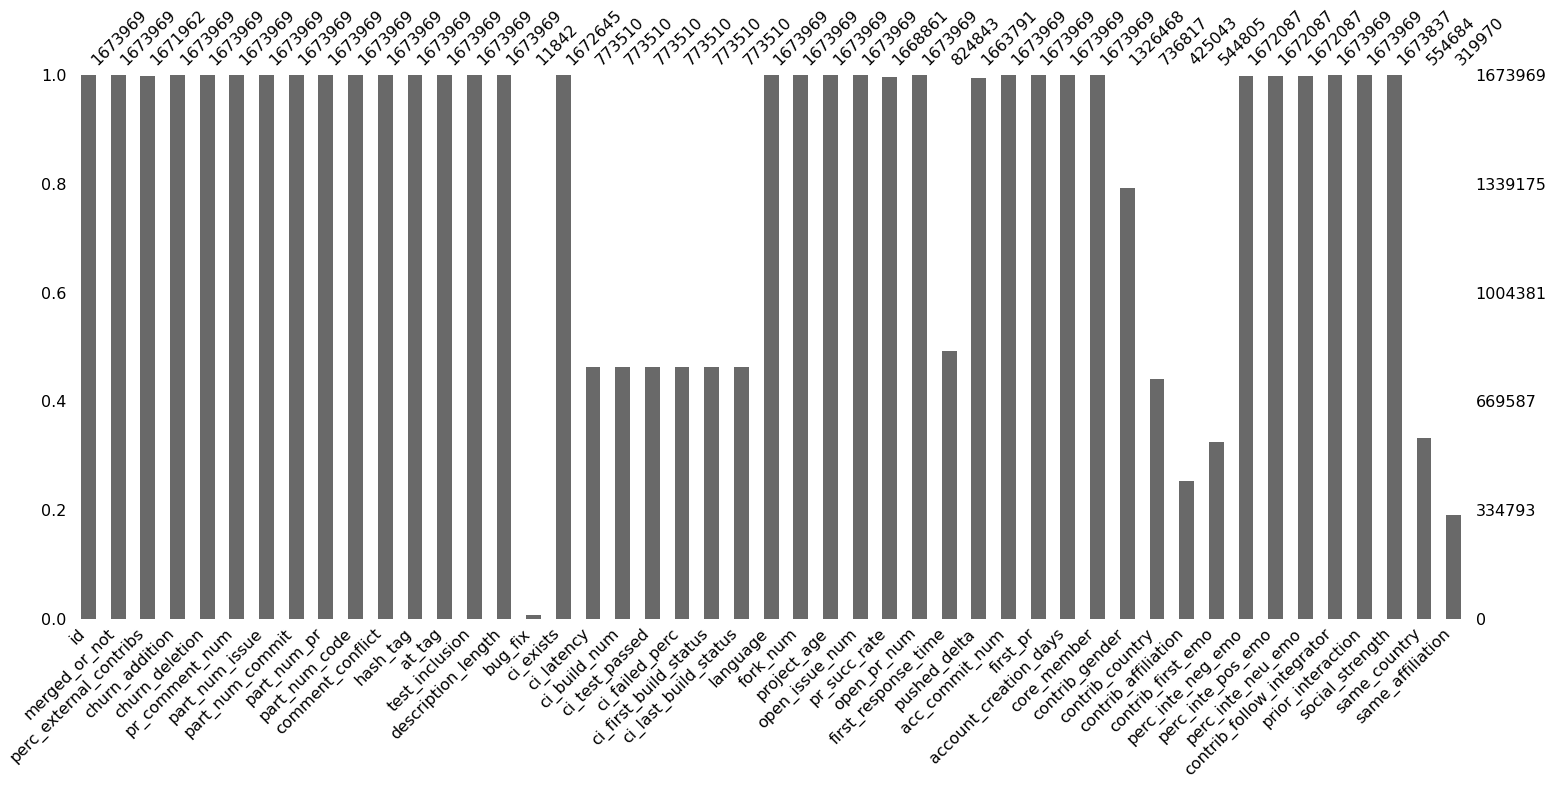

In [71]:
msno.bar(rec)

In [72]:
rec = rec.fillna(rec.mode().iloc[0])

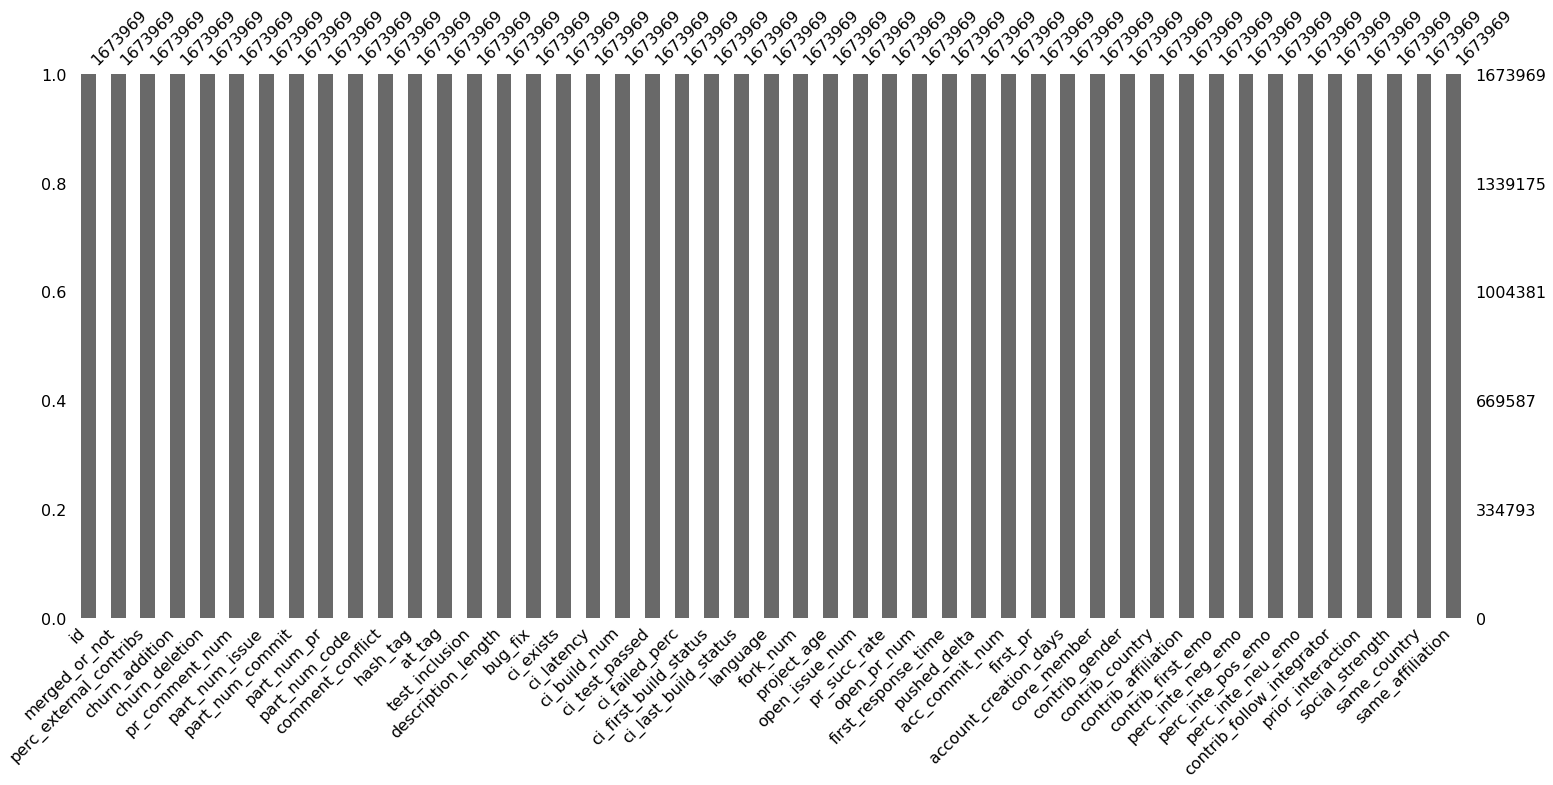

In [73]:
msno.bar(rec)

Manually annotating the metrics 'ci_first_build_status', 'ci_last_build_status', 'language', 'contrib_gender', 'contrib_country', 'contrib_affiliation' and 'contrib_first_emo' using the [dictionaries](https://colab.research.google.com/drive/1_68KgoyDN1w6K4nzdfPjaI-aoJOLTDy7?authuser=2#scrollTo=3zk8aGqsnMap&line=6&uniqifier=1) created earlier. It is possible that one or many keys vary from the training dataset to the testing dataset. However, at this point, it would be cumbersome to manually check. Hence, it is necessary to check if the test fails and if so, assign new labels to those unique values.

In [74]:
for metric in object_metrics:
  if metric == 'ci_first_build_status':
    for key in dict_ci_first_build_status:
      value = dict_ci_first_build_status[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'ci_last_build_status':
    for key in dict_ci_last_build_status:
      value = dict_ci_last_build_status[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'language':
    for key in dict_language:
      value = dict_language[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'contrib_gender':
    for key in dict_contrib_gender:
      value = dict_contrib_gender[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'contrib_country':
    for key in dict_contrib_country:
      value = dict_contrib_country[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'contrib_affiliation':
    for key in dict_contrib_affiliation:
      value = dict_contrib_affiliation[key]
      rec[metric].replace(key, value, inplace= True)
  if metric == 'contrib_first_emo':
    for key in dict_contrib_first_emo:
      value = dict_contrib_first_emo[key]
      rec[metric].replace(key, value, inplace= True)

In [75]:
model_new_rec = xgb.XGBClassifier(max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']), min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']))

Evaluation and recommendation with Strategy 1 (Mean of the feature importance values)

In [76]:
rec_test = pd.DataFrame(columns = imp_features_1)

for feature in imp_features_1:
  rec_test[feature] = rec[feature]

rec_test

,ci_last_build_status,core_member,part_num_issue,ci_build_num,ci_first_build_status,first_pr,ci_exists,part_num_commit,acc_commit_num
1673968,1,1,3,1.0,1,0,1.0,0,797
1673969,1,1,0,1.0,1,0,1.0,0,843
1673970,1,1,0,1.0,1,0,1.0,0,69
1673971,1,1,0,1.0,1,0,1.0,0,6150
1673972,1,1,0,1.0,1,0,1.0,0,58
...,...,...,...,...,...,...,...,...,...
3347932,1,1,0,1.0,1,0,1.0,0,414
3347933,1,1,2,1.0,1,0,1.0,0,3389
3347934,1,0,2,1.0,1,0,1.0,0,2
3347935,1,0,0,1.0,1,0,0.0,0,3


In [77]:
start=datetime.now()

model_new_rec.fit(X_new_1, y)

print("Computation Time")
print(datetime.now()-start)

rec_y_pred = model_new_rec.predict(rec_test)

Computation Time
0:00:09.876772


In [ ]:
results_new_rec = (rec['merged_or_not'] == rec_y_pred)
accuracy_new_rec = results_new_rec.sum() / results_new_rec.size
print(accuracy_new_rec)

0.8198682293399698


Evaluation for: Model Perfomance on Evaluation Data
              precision    recall  f1-score   support

    Rejected      0.598     0.170     0.264    319295
    Accepted      0.833     0.973     0.897   1354674

    accuracy                          0.820   1673969
   macro avg      0.715     0.571     0.581   1673969
weighted avg      0.788     0.820     0.777   1673969



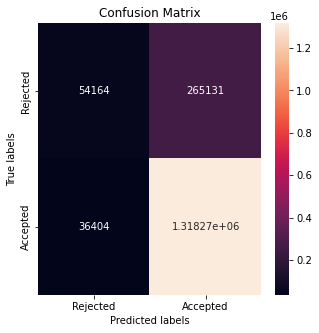

In [ ]:
print(evaluation_summary("Model Perfomance on Evaluation Data", rec["merged_or_not"], rec_y_pred, target_classes))

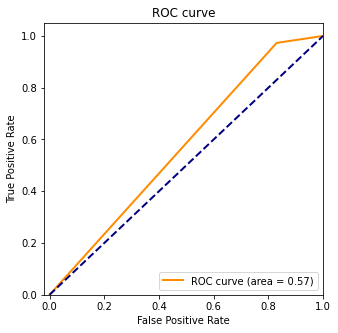

In [ ]:
roc_auc_curve(rec['merged_or_not'], rec_y_pred)

Using SHAP to determine the underperforming features among the lot.

In [78]:
import shap

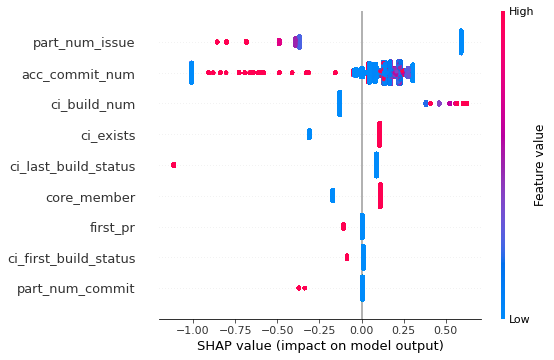

In [80]:
explainer = shap.TreeExplainer(model_new_rec)
shap_values = explainer.shap_values(rec_test)

shap.initjs()
shap.summary_plot(shap_values, rec_test)

Pull-request characteristics that could be possibly changed.

In [81]:
reco_strategy1 = recommendation_metrics(imp_features_1, pull_request_characteristics)
for feature in reco_strategy1:
  print(feature," can be used for recommendation.")

ci_last_build_status  can be used for recommendation.
ci_build_num  can be used for recommendation.
ci_first_build_status  can be used for recommendation.
ci_exists  can be used for recommendation.


In [82]:
data = train_test.copy(deep=True)
data_columns = data.columns.to_list()
for features in data_columns:
  if features == "merged_or_not":
    continue
  elif features not in reco_strategy1:
    data.drop(features, axis=1, inplace = True)

data = data.drop(data[data.merged_or_not == 0].index)
data

,merged_or_not,ci_exists,ci_build_num,ci_first_build_status,ci_last_build_status
0,1,1.0,1.0,1,1
2,1,1.0,1.0,1,1
3,1,1.0,1.0,1,1
4,1,1.0,1.0,1,1
5,1,1.0,1.0,1,1
...,...,...,...,...,...
1673962,1,0.0,1.0,1,1
1673963,1,1.0,2.0,1,1
1673964,1,1.0,2.0,1,2
1673965,1,1.0,1.0,1,1


In [83]:
compare = rec.copy(deep=True)
compare_columns = compare.columns.to_list()

for features in compare_columns:
  if features not in reco_strategy1:
    compare.drop(features, axis=1, inplace = True)

compare.insert(0, 'predicted_merged_or_not', rec_y_pred)
compare = compare.drop(compare[compare.predicted_merged_or_not == 1].index)
compare

,predicted_merged_or_not,ci_exists,ci_build_num,ci_first_build_status,ci_last_build_status
1673977,0,1.0,9.0,1,1
1673984,0,1.0,1.0,1,1
1674012,0,1.0,1.0,1,1
1674019,0,1.0,1.0,1,1
1674029,0,1.0,13.0,1,2
...,...,...,...,...,...
3347870,0,1.0,1.0,2,2
3347874,0,1.0,1.0,1,1
3347894,0,1.0,1.0,1,1
3347896,0,1.0,1.0,1,1


In [84]:
for features in reco_strategy1:
  print("Merged requests mostly had '",data[features].value_counts().idxmax(),
        "', whereas unmerged requests mostly had '", 
        compare[features].value_counts().idxmax(),"' in ", features)

Merged requests mostly had ' 1 ', whereas unmerged requests mostly had ' 1 ' in  ci_last_build_status
Merged requests mostly had ' 1.0 ', whereas unmerged requests mostly had ' 1.0 ' in  ci_build_num
Merged requests mostly had ' 1 ', whereas unmerged requests mostly had ' 1 ' in  ci_first_build_status
Merged requests mostly had ' 1.0 ', whereas unmerged requests mostly had ' 1.0 ' in  ci_exists


In [85]:
del data
del compare
del rec_test

Evaluation and recommendation with Strategy 4.

In [92]:
rec_test = pd.DataFrame(columns = imp_features_4)

for feature in imp_features_4:
  rec_test[feature] = rec[feature]

rec_test

,part_num_issue,prior_interaction,ci_latency,fork_num,acc_commit_num,first_response_time,social_strength,pr_succ_rate,perc_external_contribs,pushed_delta
1673968,3,193,125.0,132,797,135.0,0.333333,0.970787,0.010695,304038.0
1673969,0,128,2336.0,205,843,0.0,0.210526,0.984974,0.190860,8146.0
1673970,0,41,125.0,1,69,0.0,0.222222,0.958042,0.083893,1206410.0
1673971,0,847,1092.0,591,6150,0.0,0.314286,0.969887,0.000404,7725.0
1673972,0,61,125.0,18,58,0.0,0.170732,1.000000,0.082583,2277.0
...,...,...,...,...,...,...,...,...,...,...
3347932,0,30,125.0,0,414,0.0,0.000000,1.000000,0.000000,18087.0
3347933,2,865,125.0,2454,3389,41.0,0.268293,0.965155,0.277100,431.0
3347934,2,2,125.0,125,2,9.0,0.083333,0.992126,0.109677,78766.0
3347935,0,13,125.0,84,3,0.0,0.157895,0.991597,0.154545,995650.0


In [93]:
start=datetime.now()

model_new_rec.fit(X_new_4, y)

print("Computation Time")
print(datetime.now()-start)

rec_y_pred = model_new_rec.predict(rec_test)

Computation Time
0:00:30.019569


In [94]:
results_new_rec = (rec['merged_or_not'] == rec_y_pred)
accuracy_new_rec = results_new_rec.sum() / results_new_rec.size
print(accuracy_new_rec)

0.8207529530116746


Evaluation for: Model Perfomance on Evaluation Data
              precision    recall  f1-score   support

    Rejected      0.639     0.138     0.228    319295
    Accepted      0.829     0.982     0.899   1354674

    accuracy                          0.821   1673969
   macro avg      0.734     0.560     0.563   1673969
weighted avg      0.792     0.821     0.771   1673969



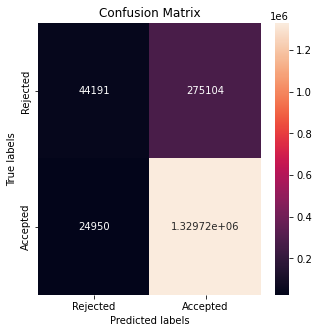

In [95]:
print(evaluation_summary("Model Perfomance on Evaluation Data", rec["merged_or_not"], rec_y_pred, target_classes))

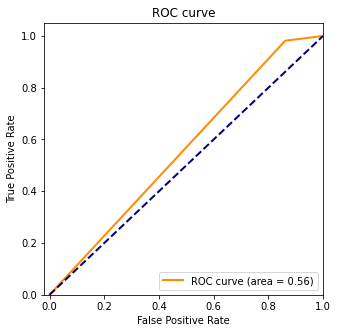

In [96]:
roc_auc_curve(rec['merged_or_not'], rec_y_pred)

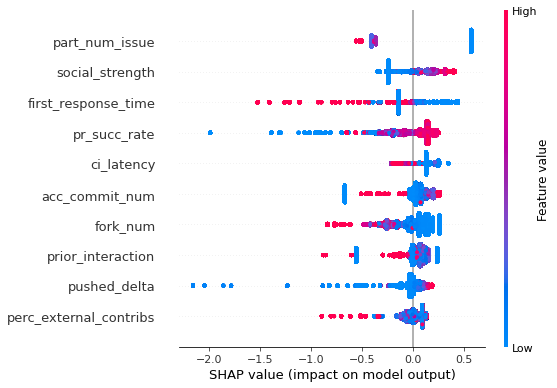

In [97]:
explainer = shap.TreeExplainer(model_new_rec)
shap_values = explainer.shap_values(rec_test)

shap.initjs()
shap.summary_plot(shap_values, rec_test)

In [98]:
reco_strategy4 = recommendation_metrics(imp_features_4, pull_request_characteristics)
for feature in reco_strategy4:
  print(feature," can be used for recommendation.")

ci_latency  can be used for recommendation.


In [99]:
data = train_test.copy(deep=True)
data_columns = data.columns.to_list()
for features in data_columns:
  if features == "merged_or_not":
    continue
  elif features not in reco_strategy4:
    data.drop(features, axis=1, inplace = True)

data = data.drop(data[data.merged_or_not == 0].index)
data

,merged_or_not,ci_latency
0,1,274.0
2,1,88.0
3,1,489.0
4,1,261.0
5,1,120.0
...,...,...
1673962,1,120.0
1673963,1,476.0
1673964,1,11881.0
1673965,1,120.0


In [100]:
compare = rec.copy(deep=True)
compare_columns = compare.columns.to_list()

for features in compare_columns:
  if features not in reco_strategy4:
    compare.drop(features, axis=1, inplace = True)

compare.insert(0, 'predicted_merged_or_not', rec_y_pred)
compare = compare.drop(compare[compare.predicted_merged_or_not == 1].index)
compare

,predicted_merged_or_not,ci_latency
1673977,0,2541.0
1674004,0,7410.0
1674019,0,125.0
1674030,0,125.0
1674055,0,8678.0
...,...,...
3347785,0,1229.0
3347798,0,125.0
3347870,0,96.0
3347894,0,3787.0


In [101]:
for features in reco_strategy4:
  print("Merged requests mostly had '",data[features].value_counts().idxmax(),
        "', whereas unmerged requests mostly had '", 
        compare[features].value_counts().idxmax(),"' in ", features)

Merged requests mostly had ' 120.0 ', whereas unmerged requests mostly had ' 125.0 ' in  ci_latency


In [102]:
del data
del compare
del rec_test

Understanding the Shapley Value [here](https://christophm.github.io/interpretable-ml-book/shapley.html). [More](https://arxiv.org/pdf/2102.10936.pdf) things about Shapley.

Interpreting the SHAP plot:
1. The y-axis indicates importance of the metrics with the top-most one being the most important one and the bottom one being the least important metric.
2. The x-axis is the SHAP values, indiacting the change in log-odds.
3. Gradient color indicates the original value for that variable. 
4. Each point represents the row from the original dataset.

[Reference] [link text](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)

1. Check [this](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) out.
2. Check [this](https://www.kaggle.com/general/237792) out.
3. Check [this](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook) out for more XGBoost information.

Check [this](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) out for parameter tuning.

Click [here](https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook), [here](https://gmd.copernicus.org/preprints/gmd-2020-59/gmd-2020-59.pdf), [here](https://stackoverflow.com/questions/69937376/explaination-of-shap-value-from-xgboost) for more SHAP related documents.

For BEAM, look at actionable features and come up with why you can recommend something before the recommendation.

# **BEAM**
Study [this](https://www.width.ai/post/what-is-beam-search)

In [ ]:
reco = []
for feature in imp_features_1:
  if feature in pull_request_characteristics:
    reco.append(feature)
    print(feature," can be used for recommendation.")

ci_last_build_status  can be used for recommendation.
ci_build_num  can be used for recommendation.
ci_first_build_status  can be used for recommendation.
ci_exists  can be used for recommendation.


In [ ]:
print(train_test['merged_or_not'].value_counts())

1    1355422
0     318546
Name: merged_or_not, dtype: int64


In [ ]:
chunk_size = len(df)/2
get_chunk = flow_from_df(df, int(chunk_size))
data = next(get_chunk)
data

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,8504763,1205,20816393,os-autoinst,openQA,1,77,77.0,1,...,1,2,0,0,6.0,1,0.119597,0,77,0
1673964,1673965,10789805,141,4184228,geopandas,geopandas,1,418,418.0,4,...,1,2,0,0,48.0,0,0.037736,0,418,0
1673965,1673966,26051663,5794,45711167,JMRI,JMRI,1,151,151.0,1,...,0,0,0,0,51.0,0,0.094772,0,151,0
1673966,1673967,4952323,91,2361445,spring-projects,spring-data-mongodb,0,122689,NaN,3,...,0,0,0,0,149.0,0,0.478788,0,122689,0


In [ ]:
data = data.drop('id', axis = 1)
data = data.drop(data[data.merged_or_not == 0].index)
data_columns = data.columns.to_list()

for features in data_columns:
    if features not in imp_features_1 or features in reco:
        data.drop(features, axis=1, inplace = True)

In [ ]:
for features in reco:
    data.insert(loc = len(data.columns), column = features, value = train_test[features])
    
data

,part_num_issue,part_num_commit,acc_commit_num,first_pr,core_member,ci_last_build_status,ci_build_num,ci_first_build_status,ci_exists
0,1,0,28,0,0,1,1.0,1,1.0
2,0,0,652,0,1,1,1.0,1,1.0
3,0,0,1050,0,1,1,1.0,1,1.0
4,1,0,10,0,0,1,1.0,1,1.0
5,0,0,452,0,1,1,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...
1673962,1,0,1,1,0,1,1.0,1,0.0
1673963,3,0,498,0,1,1,2.0,1,1.0
1673964,4,0,20,0,1,2,2.0,1,1.0
1673965,0,0,4523,0,1,1,1.0,1,1.0


In [ ]:
beam_columns = rec.columns.to_list()
beam_columns.insert(0, 'id', )
beam_columns.insert(1, 'predicted_merged_or_not')
beam_columns

['id',
 'predicted_merged_or_not',
 'id',
 'merged_or_not',
 'perc_external_contribs',
 'churn_addition',
 'churn_deletion',
 'pr_comment_num',
 'part_num_issue',
 'part_num_commit',
 'part_num_pr',
 'part_num_code',
 'comment_conflict',
 'hash_tag',
 'at_tag',
 'test_inclusion',
 'description_length',
 'bug_fix',
 'ci_exists',
 'ci_latency',
 'ci_build_num',
 'ci_test_passed',
 'ci_failed_perc',
 'ci_first_build_status',
 'ci_last_build_status',
 'language',
 'fork_num',
 'project_age',
 'open_issue_num',
 'pr_succ_rate',
 'open_pr_num',
 'first_response_time',
 'pushed_delta',
 'acc_commit_num',
 'first_pr',
 'account_creation_days',
 'core_member',
 'contrib_gender',
 'contrib_country',
 'contrib_affiliation',
 'contrib_first_emo',
 'perc_inte_neg_emo',
 'perc_inte_pos_emo',
 'perc_inte_neu_emo',
 'contrib_follow_integrator',
 'prior_interaction',
 'social_strength',
 'same_country',
 'same_affiliation']

In [ ]:
rec

,part_num_issue,part_num_commit,acc_commit_num,first_pr,core_member
1673968,3,0,797,0,1
1673969,0,0,843,0,1
1673970,0,0,69,0,1
1673971,0,0,6150,0,1
1673972,0,0,58,0,1
...,...,...,...,...,...
3347932,0,0,414,0,1
3347933,2,0,3389,0,1
3347934,2,0,2,0,0
3347935,0,0,3,0,0


In [ ]:
beam = rec.copy(deep=True)

preprocess_cols = rec.columns
print(preprocess_cols)
print(imp_features_1)
for features in preprocess_cols:
    if features not in imp_features_1 and features not in reco:
        beam.drop(features, axis=1, inplace = True)
        
beam

Index(['part_num_issue', 'part_num_commit', 'acc_commit_num', 'first_pr',
       'core_member'],
      dtype='object')
['ci_last_build_status', 'core_member', 'part_num_issue', 'ci_build_num', 'ci_first_build_status', 'first_pr', 'ci_exists', 'part_num_commit', 'acc_commit_num']


,part_num_issue,part_num_commit,acc_commit_num,first_pr,core_member
1673968,3,0,797,0,1
1673969,0,0,843,0,1
1673970,0,0,69,0,1
1673971,0,0,6150,0,1
1673972,0,0,58,0,1
...,...,...,...,...,...
3347932,0,0,414,0,1
3347933,2,0,3389,0,1
3347934,2,0,2,0,0
3347935,0,0,3,0,0


In [ ]:
for features in reco:
    beam.drop(features, axis=1, inplace = True)

for features in reco:
    beam.insert(loc = len(beam.columns), column = features, value = rec[features])
    

beam.insert(loc = 0, column = 'id', value = rec['id'])
beam.insert(loc = 1, column = 'predicted_merged_or_not', value = rec_y_pred)

beam

NameError: ignored

The following code cell was inspired by the blog post "[How to Implement a Beam Search Encoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)" and "[Sequence Generation with Beam Search Sampler and Sequence Sampler](https://nlp.gluon.ai/examples/sequence_sampling/sequence_sampling.html)".



1. [BEAM Search Explanation](https://www.baeldung.com/cs/beam-search)
2. [BEAM Search Implementation for sequence](https://edward-rees.com/beam-search)
3. [Pharaoh](https://link.springer.com/chapter/10.1007/978-3-540-30194-3_13?LI=true)
4. [BEAM Search for Sequence Generation](https://www.width.ai/post/what-is-beam-search)



Training the LSTM based Language Model.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import glob
import time
import math

import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon.utils import download

import gluonnlp as nlp
nlp.utils.check_version('0.7.0')

Setting GPU to 1 as only one is available as resource. Change according to need/ requirement.

In [ ]:
num_gpus = 1
context = [mx.gpu(i) for i in range(num_gpus)] if num_gpus else [mx.cpu()]
log_interval = 200

Setting up hyperparameters for the Language Model.

In [ ]:
batch_size = 20 * len(context)
lr = 20
epochs = 3
bptt = 35 #back propagation through time
grad_clip = 0.25

Loading the dataset

In [ ]:
len(data)

In [ ]:
data_vocab = data.to_numpy().tolist()
print(data_vocab[1])
print(type(data_vocab))

In [ ]:
flat_list_data = [int(item) for sublist in data_vocab for item in sublist]
flat_list_data[0]

In [ ]:
for i in flat_list_data:
    print(i)
    print(flat_list_data[i])
    combination_data = str(flat_list_data[i])
    counter = nlp.data.count_tokens(combination_data)
    
my_vocab = nlp.Vocab(counter)

In [ ]:
import mxnet as mx
import gluonnlp as nlp
nlp.utils.check_version('0.8.0')

ctx = mx.cpu()
lm_model, vocab = nlp.model.get_model(name='awd_lstm_lm_1150',
                                      dataset_name='wikitext-2',
                                      pretrained=True,
                                      ctx=ctx)

In [ ]:
scorer = nlp.model.BeamSearchScorer(alpha=0, K=5, from_logits=False)

In [ ]:

class LMDecoder(object):
    def __init__(self, model):
        self._model = model
    def __call__(self, inputs, states):
        outputs, states = self._model(mx.nd.expand_dims(inputs, axis=0), states)
        return outputs[0], states
    def state_info(self, *arg, **kwargs):
        return self._model.state_info(*arg, **kwargs)
    
decoder = LMDecoder(lm_model)

In [ ]:
eos_id = vocab['.']
beam_sampler = nlp.model.BeamSearchSampler(beam_size=5,
                                           decoder=decoder,
                                           eos_id=eos_id,
                                           scorer=scorer,
                                           max_length=20)

In [ ]:
start = ''.join([str(beam['part_num_issue'][0]), str(beam['part_num_commit'][0])])
print(start)

In [ ]:
bos = start.split()
bos_ids = [vocab[ele] for ele in bos]
begin_states = lm_model.begin_state(batch_size=1, ctx=ctx)
if len(bos_ids) > 1:
    _, begin_states = lm_model(mx.nd.expand_dims(mx.nd.array(bos_ids[:-1]), axis=1),
                               begin_states)
inputs = mx.nd.full(shape=(1,), ctx=ctx, val=bos_ids[-1])

In [ ]:
def generate_sequences(sampler, inputs, begin_states, num_print_outcomes):

    samples, scores, valid_lengths = sampler(inputs, begin_states)
    samples = samples[0].asnumpy()
    scores = scores[0].asnumpy()
    valid_lengths = valid_lengths[0].asnumpy()
    print('Generation Result:')

    for i in range(num_print_outcomes):
        sentence = bos[:-1]

        for ele in samples[i][:valid_lengths[i]]:
            sentence.append(vocab.idx_to_token[ele])

        print([' '.join(sentence), scores[i]])

In [ ]:
generate_sequences(beam_sampler, inputs, begin_states, 1)

The following code cell was inspired by the blog post "[How to Implement a Beam Search Encoder for Natural Language Processing](https://https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)"

In [ ]:
'''
def beam_search(data, k):
  sequences = [[list(), 0.0]]
	for row in data:
		all_candidates = list()
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		sequences = ordered[:k]
	return sequences
'''

'\ndef beam_search(data, k):\n  sequences = [[list(), 0.0]]\n\tfor row in data:\n\t\tall_candidates = list()\n\t\tfor i in range(len(sequences)):\n\t\t\tseq, score = sequences[i]\n\t\t\tfor j in range(len(row)):\n\t\t\t\tcandidate = [seq + [j], score - log(row[j])]\n\t\t\t\tall_candidates.append(candidate)\n\t\tordered = sorted(all_candidates, key=lambda tup:tup[1])\n\t\tsequences = ordered[:k]\n\treturn sequences\n'

In [ ]:
'''
def recommend():
  original_pull_request = {}
  recommended_pull_request = {}
  for rows in beam.itertuples():
    if rows.predicted_merged_or_not == 0:
      original_pull_request = beam.to_dict
      #original_pull_request = rows.to_dict()
      print(original_pull_request)
      print(type(original_pull_request))
      break
      #recommended_pull_request = beam_search()
'''

In [ ]:
'''
choice = input("Do you want recommendations? Press Y/y for yes and N/n for no.")
if choice.lower() ==  'y':
  recommend()
else:
  print("Experiment Completed. Thank you!!")
'''

Do you want recommendations? Press Y/y for yes and N/n for no.y


AttributeError: ignored